# Loadin Dataset


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import seaborn as sns
from imblearn.over_sampling import SMOTE

#read the dataset
df = pd.read_csv('train_dataset.csv', encoding='ISO-8859-1')

# drop the column named label of the dataset
df = df.drop(['label'], axis=1)
 
# #check the shape of the dataset
# print("n_records:", df.shape[0])

#check duplicates in the dataset
print("Duplicates: ", df.duplicated().sum())

#check null values
print("Null values: ", df.isnull().sum().sum())


#check the unique values of the dataset
print("Unique values: ", df.nunique())

# Identify categorical columns
# print("categorical columns")
categorical_cols = df.select_dtypes(include=['object']).columns
# print(categorical_cols)


# Replace '-' with NaN and convert only numeric columns to float
df.replace('-', np.nan, inplace=True)
print("servizio prima: ", df["service"][0])
#print type of the columns
print(df.dtypes)

#replace nan values for the numeric columns with the mean of the column
for col in df.columns:
    if (df[col].dtype == 'float64' or df[col].dtype == 'int64'):
        df[col] = df[col].fillna(df[col].mean())
    elif(df[col].dtype == 'object'):
        df[col] = df[col].fillna(df[col].mode()[0])

print("servizio dopo: ", df["service"][0])

Matplotlib is building the font cache; this may take a moment.
/var/folders/nd/w5k06k917hbg7rpdv3ty357c0000gn/T/ipykernel_36319/2945627321.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_dataset.csv', encoding='ISO-8859-1')


Duplicates:  0
Null values:  0
Unique values:  ts                        151968
src_ip                       818
src_port                   57822
dst_ip                      1678
dst_port                   47556
proto                          3
service                       23
duration                  209355
src_bytes                   4355
dst_bytes                   3897
conn_state                    13
missed_bytes                1299
src_pkts                     447
src_ip_bytes                4598
dst_pkts                     137
dst_ip_bytes                4066
dns_query                   2231
dns_qclass                     3
dns_qtype                     11
dns_rcode                      4
dns_AA                         3
dns_RD                         3
dns_RA                         3
dns_rejected                   3
ssl_version                    5
ssl_cipher                     7
ssl_resumed                    3
ssl_established                3
ssl_subject                  

/var/folders/nd/w5k06k917hbg7rpdv3ty357c0000gn/T/ipykernel_36319/2945627321.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True)


servizio prima:  nan
ts                          int64
src_ip                     object
src_port                    int64
dst_ip                     object
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                  object
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_query                  object
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                     object
dns_RD                     object
dns_RA                     object
dns_rejected               object
ssl_version                object
ssl_cipher                 object
ssl_resumed                object
ssl_established            object
ssl_subject                

# Encoding  

In [5]:
#label encoder
le = LabelEncoder()

# Convert categorical columns to numeric
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Data Correlation Table

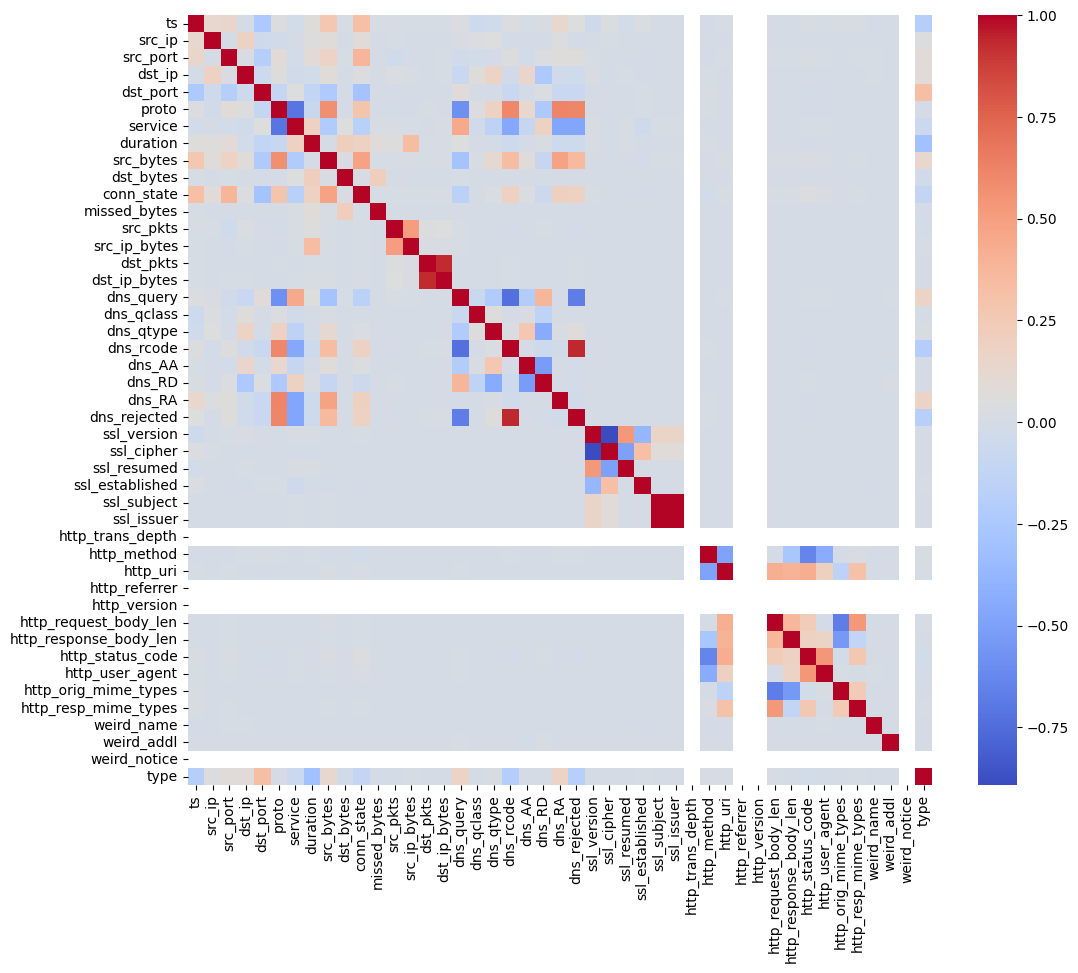

In [6]:


# Calculate correlation matrix
correlation_matrix = df.corr()

import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')


# Show the plot
plt.show()




# Outlier Detection

In [105]:
# #use IQR to remove outliers
# Q1 = df.quantile(0.2)
# Q3 = df.quantile(0.8)

# IQR = Q3 - Q1

# df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

#check the shape of the dataset
# print("n_records:", df.shape[0])
# plt.show()


n_records: 617002


# Pre-Processing

In [ ]:
#compute pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the Data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# create the PCA instance
pca = PCA(0.95)

# fit on data
pca.fit(df_scaled)

# transform data
df_pca = pca.transform(df_scaled)

print("shape of the original data: ", df_scaled.shape)
print("shape of the pca data: ", df_pca.shape)
#get the name of column of pca data
columns = ['pca'+str(i) for i in range(df_pca.shape[1])]

#convert the pca data to dataframe
df_pca = pd.DataFrame(df_pca, columns=columns)
#split the dataset into train and test
from sklearn.model_selection import train_test_split

X = df_pca
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#apply smote
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#train the model
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(X_train, y_train)

#predict the test data
y_pred = model.predict(X_test)

#check the accuracy of the model
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(y_test, y_pred))

# Compute the ROC curve for each class

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_binarized = label_binarize(y_pred, classes=np.unique(y))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(y_test_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()


shape of the original data:  (617002, 45)
shape of the pca data:  (617002, 30)


c:\Users\rinal\OneDrive\Desktop\UNIBO\DA\DA_PROJECT\daenv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\rinal\OneDrive\Desktop\UNIBO\DA\DA_PROJECT\daenv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


<!-- # Random Forest -->